# Analyse N synthesis 

created 26-09-2023

In [141]:
%matplotlib notebook

import numpy as np
import jax.numpy as jnp
import healpy as hp
from matplotlib import pyplot as plt
import glob
from importlib import reload
import pynkowski as mf   # For Minkowski Functionals

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav
import scatcovjax.plotting as plot

plot.notebook_plot_format()

In [142]:
reload(sphlib)

<module 'scatcovjax.Sphere_lib' from '/mesopsl3/home/lmousset/projet/scatcovJAX/scatcovjax/Sphere_lib.py'>

# Parameters

In [202]:
reality = True
sampling = 'mw'
multiresolution = True
nfilters = 18 # linear filters

L = 256
N = 3
epochs = 600
J_min = 4
lam=2.0

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')

J=5 J_max=8


# Make filters

<IPython.core.display.Javascript object>


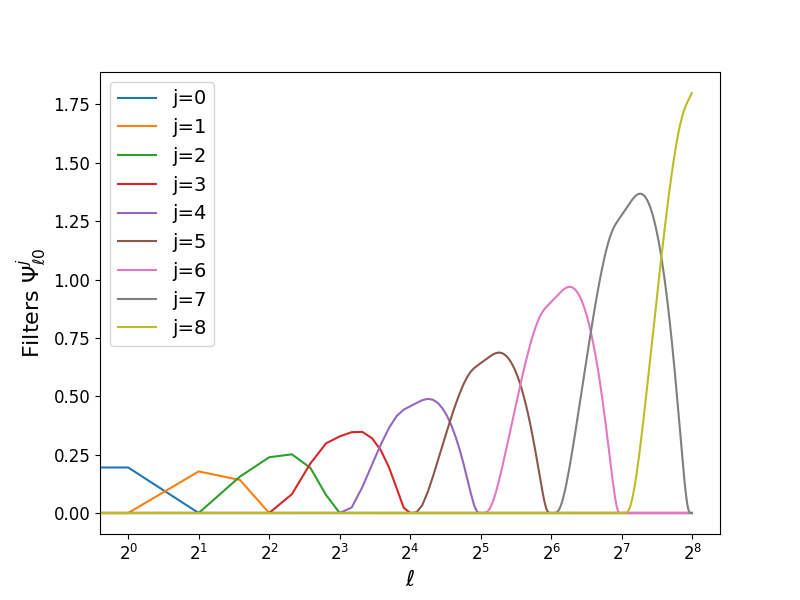

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='$\\ell$', ylabel='Filters $\\Psi^j_{\\ell 0}$'>)

In [203]:
filters = filters_directional_vectorised(L, N, J_min, lam=2)
plot.plot_filters(filters, real=True, m=L-1)

# Load the data

In [204]:
# List of job with these parameters
job_list = glob.glob(f'/travail/lmousset/scatJAX_tests_nov2023/*tSZ*_L{L}_N{N}_Jmin{J_min}_nfilters{nfilters}_epochs{epochs}*')

njob = len(job_list)
print(njob, job_list)



1 ['/travail/lmousset/scatJAX_tests_nov2023/Job10128_tSZ_L256_N3_Jmin4_nfilters18_epochs600_nreals50']


In [205]:
allflm_start, allflm_end = [], []
allloss_history = []
allcoeffs_start, allcoeffs_end= [], []
for j in range(njob):
    output_dir = job_list[j]
    print(f'\n job {j}', output_dir)
    
    nreals = int(output_dir[-2:])
    print('Number of realisations:', nreals)
    for r in range(nreals):

        if nreals == 1:
            # flm
            flm_target = jnp.load(output_dir + '/flm_target.npy')
            allflm_start.append(jnp.load(output_dir + '/flm_start.npy'))
            allflm_end.append(jnp.load(output_dir + '/flm_end.npy'))
            print(flm_target.shape)

            # Loss
            allloss_history.append(jnp.load(output_dir + '/loss.npy'))

            # Coeffs
            coeffs_target = jnp.load(output_dir + '/coeffs_target.npy', allow_pickle=True)
            allcoeffs_start.append(jnp.load(output_dir + '/coeffs_start.npy', allow_pickle=True))
            allcoeffs_end.append(jnp.load(output_dir + '/coeffs_end.npy', allow_pickle=True))
        else:
             # flm
            flm_target = jnp.load(output_dir + f'/flm_target.npy')
            allflm_start.append(jnp.load(output_dir + f'/flm_start_{r}.npy'))
            allflm_end.append(jnp.load(output_dir + f'/flm_end_{r}.npy'))
            print(flm_target.shape)

            # Loss
            allloss_history.append(jnp.load(output_dir + f'/loss_{r}.npy'))

            # Coeffs
            coeffs_target = jnp.load(output_dir + f'/coeffs_target.npy', allow_pickle=True)
            allcoeffs_start.append(jnp.load(output_dir + f'/coeffs_start_{r}.npy', allow_pickle=True))
            allcoeffs_end.append(jnp.load(output_dir + f'/coeffs_end_{r}.npy', allow_pickle=True))
            
            


 job 0 /travail/lmousset/scatJAX_tests_nov2023/Job10128_tSZ_L256_N3_Jmin4_nfilters18_epochs600_nreals50
Number of realisations: 50
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


## Make the full flm

If reality is True, we complete the flm.

In [206]:
nreals = len(allflm_end)
print(nreals)

if reality:  # Get the full flm
    flm_target = sphlib.make_flm_full(flm_target, L)
    for r in range(nreals):
        allflm_start[r] = sphlib.make_flm_full(allflm_start[r] , L)
        allflm_end[r] = sphlib.make_flm_full(allflm_end[r], L)

50


In [207]:
flm_target.shape

(256, 511)

## Filter large scales which are not constrained

In [208]:
### Cut the flm that are not contrained 
flm_target = flm_target.at[0: int(lam**J_min) + 1, :].set(0. + 0.j)
for r in range(nreals):
    allflm_end[r] = allflm_end[r].at[0: int(lam**J_min) + 1, :].set(0. + 0.j)
    allflm_start[r] = allflm_start[r].at[0: int(lam**J_min) + 1, :].set(0. + 0.j)

## Make the maps

<IPython.core.display.Javascript object>


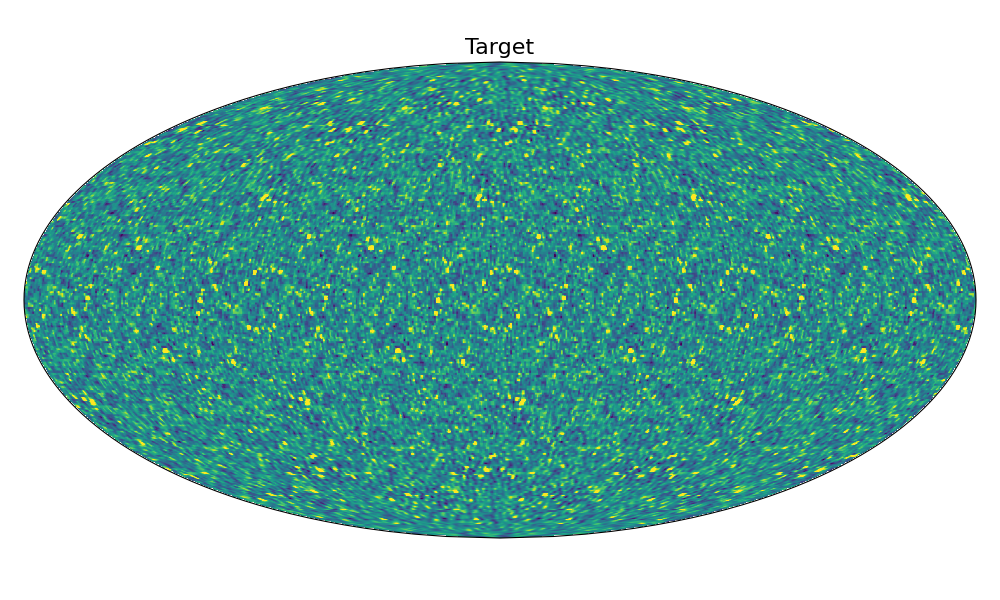

<IPython.core.display.Javascript object>


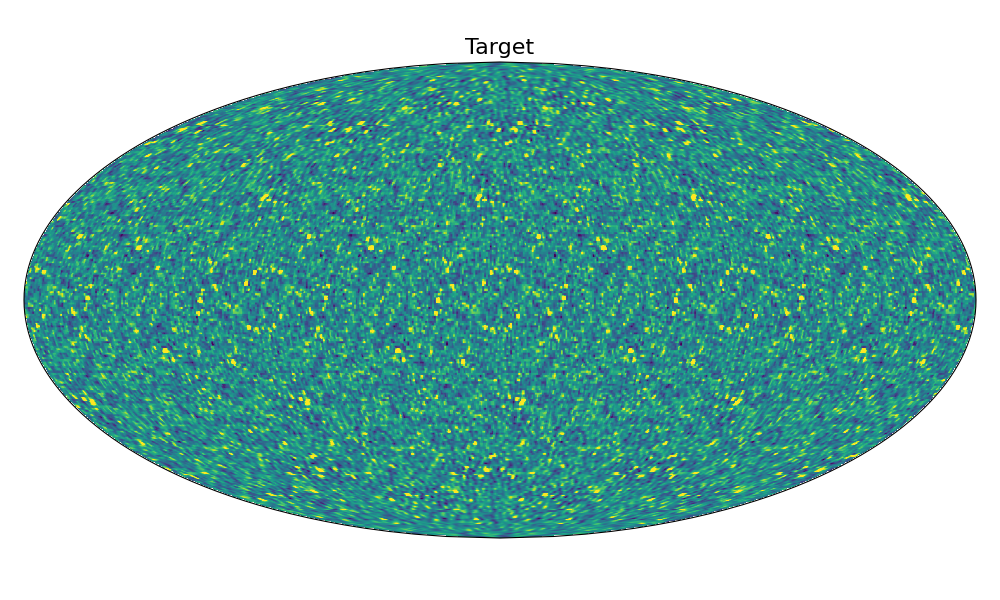

In [209]:
# Make the MW maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
mn, mx = -2, 2
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, figsize=(10, 6), title='Target')



<IPython.core.display.Javascript object>


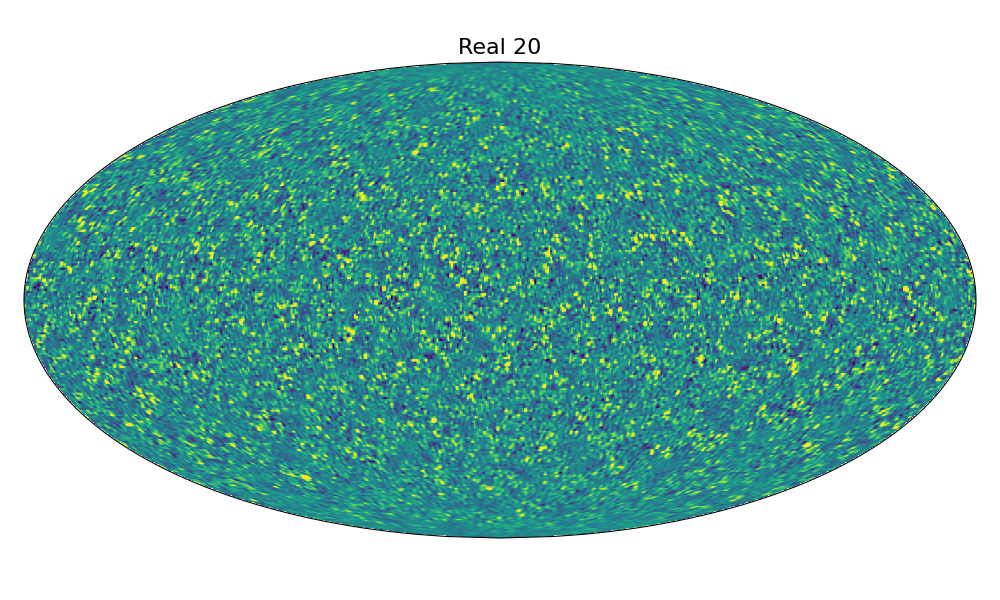

<IPython.core.display.Javascript object>


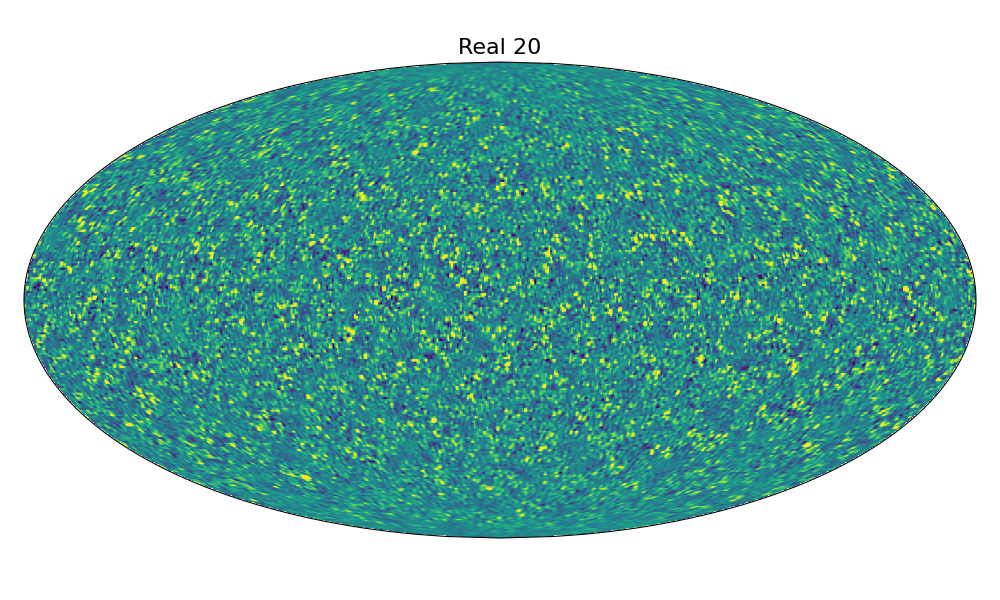

In [213]:
r = 20
f_start = s2fft.inverse_jax(allflm_start[r], L, reality=reality)
f_end = s2fft.inverse_jax(allflm_end[r], L, reality=reality)
plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, figsize=(10, 6), title=f'Real {r}')

## Make Healpix maps

In [215]:
### Convert the map in a Healpix map
nside = int(L/2)
f_target_hpx = s2fft.inverse_jax(flm_target, L, nside=nside, reality=reality, sampling='healpix')
# Take the real part and convert to a np.array
f_target_hpx = np.array(np.real(f_target_hpx))

# Plot the loss

<IPython.core.display.Javascript object>


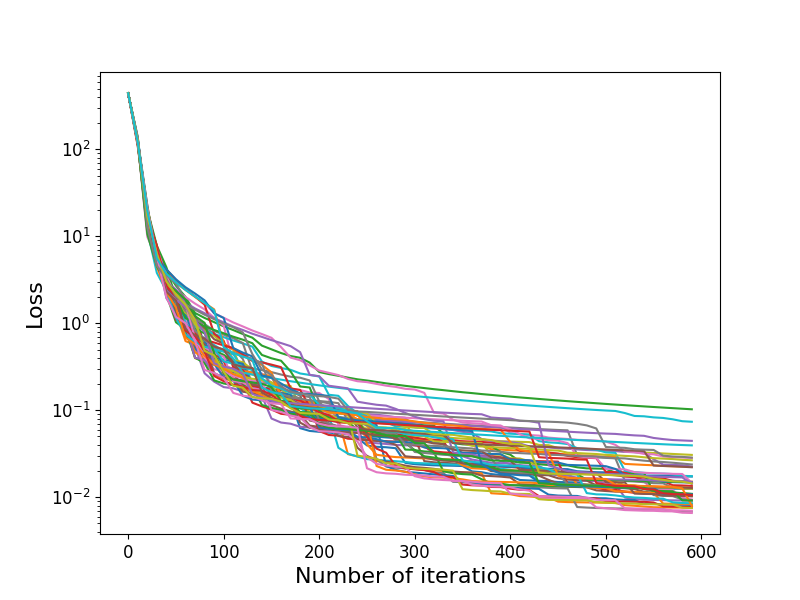

Text(0.5, 0, 'Number of iterations')

In [216]:
nit1 = epochs
step = 10

plt.figure(figsize=(8, 6))
for r in range(nreals):
    plt.plot(np.arange(0, nit1, step), allloss_history[r][:int(nit1/step)], label='All coeffs')
#plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit1/step):], 'ro--', label='All coeffs')
#plt.plot(loss_history, 'bo--')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

# Make a Gaussian realisation

Gaussian realisation with the same PS as the target.

## Make the maps and the flm

In [217]:
nside = hp.get_nside(f_target_hpx)
ngauss = 10 # Number of gaussian realisations
WN, f_gauss = np.zeros((ngauss, f_target_hpx.size), dtype=np.float64), np.zeros((ngauss, f_target_hpx.size), dtype=np.float64)
WN_lm, flm_gauss = np.zeros((ngauss, L, 2*L-1), dtype=np.complex128), np.zeros((ngauss, L, 2*L-1), dtype=np.complex128)

for n in range(ngauss):
    print(n)
    WN[n, :] = np.random.randn(f_target_hpx.size)
    WN_lm[n, :] = s2fft.forward_jax(WN[n], L=L, nside=nside, reality=reality, sampling='healpix')
    flm_gauss[n, :] = np.abs(flm_target) * WN_lm[n] / np.abs(WN_lm[n])
    f_gauss[n, :] = s2fft.inverse_jax(flm_gauss[n], L=L, nside=nside, reality=reality, sampling='healpix')


0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


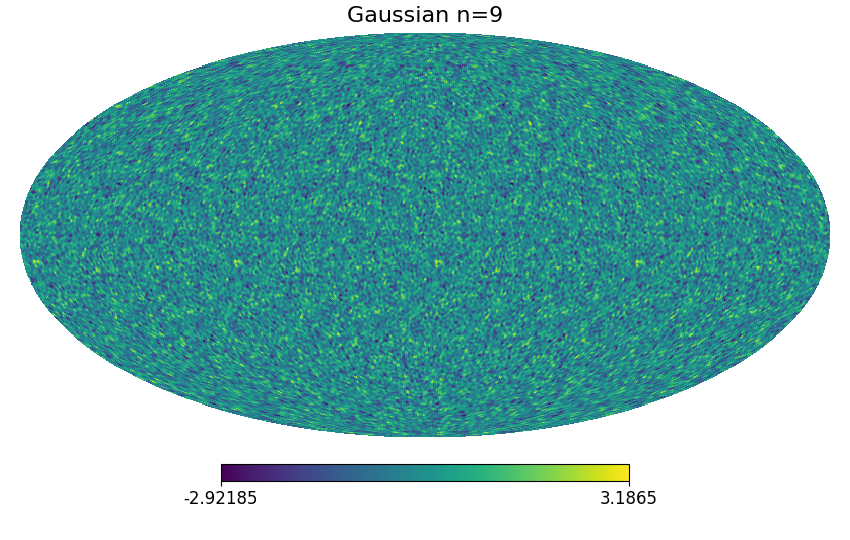

In [218]:
r = 1
hp.mollview(f_gauss[r, :], title=f'Gaussian n={n}')

## Compute the coefficients of the gaussian realisation

In [219]:
# Compute the coefficients
import scatcovjax.Fast_scattering_lib as scatlib

weights = scatlib.quadrature(L, J_min, lam, sampling, None, multiresolution)

#precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, lam, sampling, None, False,
 #                                                                    reality, multiresolution)

print('\n============ Wigner precomputes ===============')
precomps = scatlib.generate_full_precompute(L=L,
                                    N=N,
                                    J_min=J_min,
                                    lam=lam,
                                    sampling=sampling,
                                    reality=False,
                                    multiresolution=multiresolution,
                                    nside=None)


============ Wigner precomputes ===============


In [220]:
### P00 target for normalisation => used when computing gaussian flm
tP00_norm = scatlib.get_P00only(flm_target, L, N, J_min, lam, sampling, None,
                                reality=False, multiresolution=multiresolution, for_synthesis=False, 
                                normalisation=None, filters=filters[0], quads=weights, precomps=precomps)  # [J][Norient]


In [221]:
allcoeffs_gauss = []
for n in range(ngauss):
    allcoeffs_gauss.append(scatlib.scat_cov_dir(np.nan_to_num(flm_gauss[n]), L, N, J_min, lam, sampling, None,
                           reality=False, multiresolution=multiresolution, for_synthesis=True, 
                            normalisation=tP00_norm, filters=filters[0], quads=weights, precomps=precomps))


# Power spectrum

In [222]:
xx = np.arange(L)

# Target
ps_target = sphlib.compute_ps(flm_target, reality=False)


# Gaussian
allps_gauss = []
for n in range(ngauss):
    allps_gauss.append(sphlib.compute_ps(flm_gauss[n], reality=False))
    

# Start and End
allps_start, allps_end = [], []
for r in range(nreals):
    allps_start.append(sphlib.compute_ps(allflm_start[r], reality=False))
    allps_end.append(sphlib.compute_ps(allflm_end[r], reality=False))
    

# Mean and STD
allps_start = np.array(allps_start)
allps_end = np.array(allps_end)

std_ps_start = np.std(allps_start, axis=0)
std_ps_end = np.std(allps_end, axis=0)

mean_ps_start = np.mean(allps_start, axis=0)
mean_ps_end = np.mean(allps_end, axis=0)


<IPython.core.display.Javascript object>


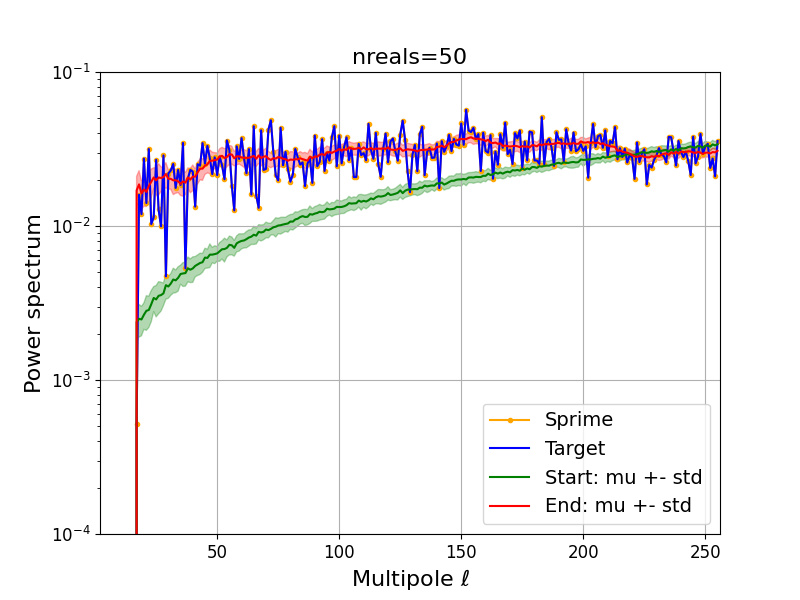

In [223]:
### Plot
plt.figure(figsize=(8, 6))
plt.title(f'{nreals=}')


plt.plot(allps_gauss[0], 'orange', marker='.', label="Sprime")

plt.plot(ps_target, 'b', label="Target")

plt.plot(mean_ps_start, 'g', label="Start: mu +- std")
plt.fill_between(xx, mean_ps_start - std_ps_start, mean_ps_start + std_ps_start, color='g', alpha=0.3)

plt.plot(mean_ps_end, 'r', label="End: mu +- std")
plt.fill_between(xx, mean_ps_end - std_ps_end, mean_ps_end + std_ps_end, color='r', alpha=0.3)

#for j in range(J):
 #   plt.plot(np.real(filters[0][j, :, L-1]))

plt.yscale("log")
#plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
plt.xlim(2, 256)
plt.ylim(1e-4, 1e-1)
plt.legend()

# Scat cov coeffs

<IPython.core.display.Javascript object>


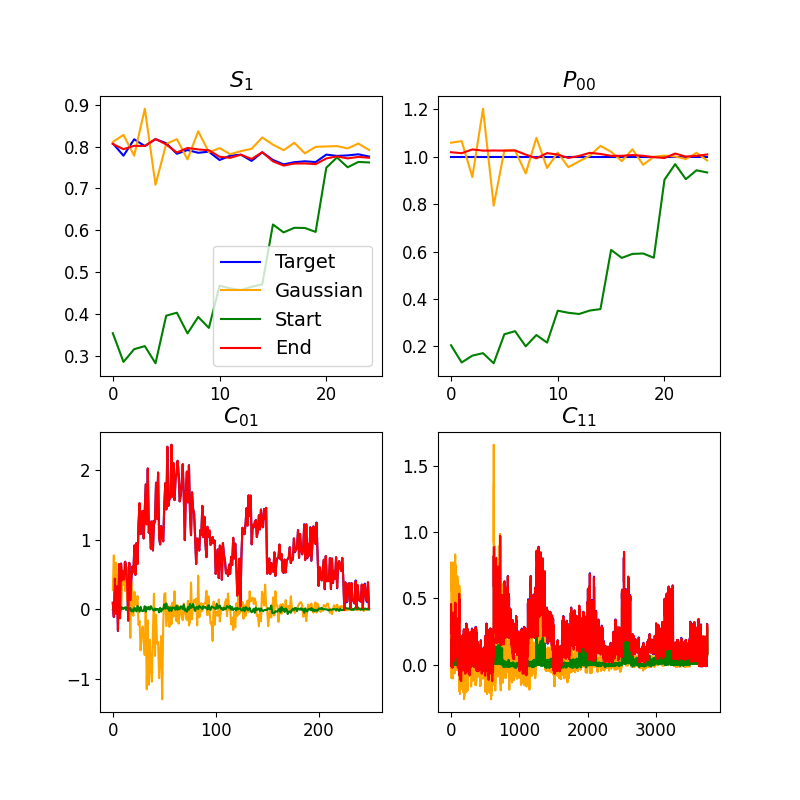

In [224]:
reload(plot)
tmean, tvar, tS1, tP00, tC01, tC11 = coeffs_target

n = 3
gmean, gvar, gS1, gP00, gC01, gC11 = allcoeffs_gauss[n]


# Do the plot for a single real
r = 2
smean, svar, sS1, sP00, sC01, sC11 = allcoeffs_start[r]
emean, evar, eS1, eP00, eC01, eC11 = allcoeffs_end[r]

plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')
plot.plot_scatcov_coeffs(gS1, gP00, gC01, gC11, name='Gaussian', hold=False, color='orange')
plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green')
plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')


# Skewness and kurtosis

In [226]:
def skewness(X):
    mu = np.mean(X)
    std = np.std(X)
    return np.mean(((X-mu) / std)**3)

def kurtosis(X):
    mu = np.mean(X)
    std = np.std(X)
    return np.mean(((X-mu) / std)**4)

In [227]:
### On the MW maps
# Skewness and kurtosis
tskew = skewness(f_target)
tkurt = kurtosis(f_target)

all_eskew = np.zeros(nreals)
all_ekurt = np.zeros(nreals)
for r in range(nreals):
    f_start = s2fft.inverse_jax(allflm_start[r], L, reality=reality, sampling='mw')
    f_end = s2fft.inverse_jax(allflm_end[r], L, reality=reality, sampling='mw')

    f_start = np.array(np.real(f_start))
    f_end = np.array(np.real(f_end))
    
    # Skewness and kurtosis
    all_eskew[r] = skewness(f_end)
    all_ekurt[r] = kurtosis(f_end)

mean_skew = np.mean(all_eskew)
mean_kurt = np.mean(all_ekurt)

std_skew = np.std(all_eskew)
std_kurt = np.std(all_ekurt)

print(tskew, mean_skew, '+-', std_skew)
print(tkurt, mean_kurt, '+-', std_kurt)

1.2457685571723396 0.8668312361610698 +- 0.00985287708148714
8.93992187178451 5.58836155513211 +- 0.07324630460467034


In [228]:
# Skewness and kurtosis
tskew = skewness(f_target_hpx)
tkurt = kurtosis(f_target_hpx)

all_eskew = np.zeros(nreals)
all_ekurt = np.zeros(nreals)
for r in range(nreals):
    f_start_hpx = s2fft.inverse_jax(allflm_start[r], L, nside=int(L/2), reality=reality, sampling='healpix')
    f_end_hpx = s2fft.inverse_jax(allflm_end[r], L, nside=int(L/2), reality=reality, sampling='healpix')

    f_start_hpx = np.array(np.real(f_start_hpx))
    f_end_hpx = np.array(np.real(f_end_hpx))
    
    # Skewness and kurtosis
    all_eskew[r] = skewness(f_end_hpx)
    all_ekurt[r] = kurtosis(f_end_hpx)

mean_skew = np.mean(all_eskew)
mean_kurt = np.mean(all_ekurt)

std_skew = np.std(all_eskew)
std_kurt = np.std(all_ekurt)

print(tskew, mean_skew, '+-', std_skew)
print(tkurt, mean_kurt, '+-', std_kurt)

1.3567412005141712 0.7886203607316792 +- 0.008196352146861062
9.942713722452245 4.880460034066038 +- 0.06392320379859658


# Histogram

In [229]:
# Do it for one real
r = 6
f_start_hpx = s2fft.inverse_jax(allflm_start[r], L, nside=int(L/2), reality=reality, sampling='healpix')
f_end_hpx = s2fft.inverse_jax(allflm_end[r], L, nside=int(L/2), reality=reality, sampling='healpix')

f_start_hpx = np.array(np.real(f_start_hpx))
f_end_hpx = np.array(np.real(f_end_hpx))

<IPython.core.display.Javascript object>


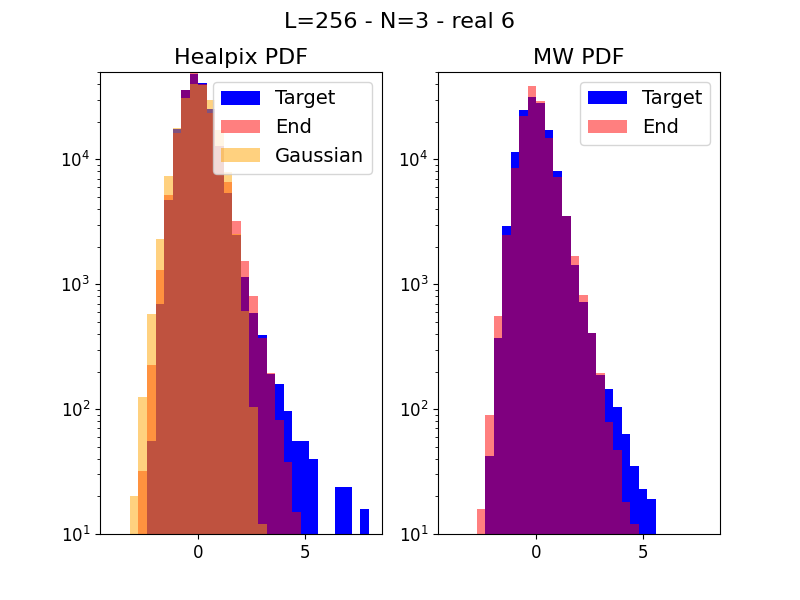

In [230]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle(f'{L=} - {N=} - real {r}')
histrange = (-4, 8)

ax0.hist(f_target_hpx, bins=30, range=histrange,
         density=False, color='b', alpha=1., label=f'Target')
ax0.hist(f_end_hpx, bins=30, range=histrange, 
         density=False, color='r', alpha=0.5, label=f'End')
ax0.hist(f_gauss[0], bins=30, range=histrange, 
         density=False, color='orange', alpha=0.5, label=f'Gaussian')
ax0.set_title('Healpix PDF')
ax0.set_yscale("log")
ax0.set_ylim(10, 5e4)
ax0.legend()

ax1.hist(np.ravel(f_target), bins=30, range=histrange, 
         density=False, color='b', alpha=1, label='Target')
ax1.hist(np.ravel(f_end), bins=30, range=histrange, 
         density=False, color='r', alpha=0.5, label='End')
ax1.set_title('MW PDF')
ax1.set_yscale("log")
ax1.set_ylim(10, 5e4)
ax1.legend()

# Minkowski

In [231]:
def make_minkowski(us, map_hpx):

    data = mf.Healpix(map_hpx, normalise=True, mask=None)     # Default parameters
    v0 = mf.V0(data, us)
    v1 = mf.V1(data, us)
    v2 = mf.V2(data, us)
    
    return v0, v1, v2

In [232]:
us = np.arange(-5., 7.01, 0.1)

# Target
v0_target, v1_target, v2_target = make_minkowski(us, f_target_hpx)

# Gaussian real
all_v0_gauss, all_v1_gauss, all_v2_gauss  = np.zeros((ngauss, v0_target.size)), np.zeros((ngauss, v0_target.size)), np.zeros((ngauss, v0_target.size))
for n in range(ngauss):
    all_v0_gauss[n], all_v1_gauss[n], all_v2_gauss[n] = make_minkowski(us, f_gauss[n, :])
 
# Start and End
all_v0_start, all_v1_start, all_v2_start  = np.zeros((nreals, v0_target.size)), np.zeros((nreals, v0_target.size)), np.zeros((nreals, v0_target.size))
all_v0_end, all_v1_end, all_v2_end  = np.zeros((nreals, v0_target.size)), np.zeros((nreals, v0_target.size)), np.zeros((nreals, v0_target.size))
for r in range(nreals):
    f_start_hpx = s2fft.inverse_jax(allflm_start[r], L, nside=int(L/2), reality=reality, sampling='healpix')
    f_end_hpx = s2fft.inverse_jax(allflm_end[r], L, nside=int(L/2), reality=reality, sampling='healpix')

    f_start_hpx = np.array(np.real(f_start_hpx))
    f_end_hpx = np.array(np.real(f_end_hpx))
    
    all_v0_start[r], all_v1_start[r], all_v2_start[r] = make_minkowski(us, f_start_hpx)
    all_v0_end[r], all_v1_end[r], all_v2_end[r] = make_minkowski(us, f_end_hpx)



  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [233]:
# Gaussian 
mean_v0_gauss = np.mean(all_v0_gauss, axis=0)
mean_v1_gauss = np.mean(all_v1_gauss, axis=0)
mean_v2_gauss = np.mean(all_v2_gauss, axis=0)

std_v0_gauss = np.std(all_v0_gauss, axis=0)
std_v1_gauss = np.std(all_v1_gauss, axis=0)
std_v2_gauss = np.std(all_v2_gauss, axis=0)

# Start and End
mean_v0_start = np.mean(all_v0_start, axis=0)
mean_v1_start = np.mean(all_v1_start, axis=0)
mean_v2_start = np.mean(all_v2_start, axis=0)

mean_v0_end = np.mean(all_v0_end, axis=0)
mean_v1_end = np.mean(all_v1_end, axis=0)
mean_v2_end = np.mean(all_v2_end, axis=0)

std_v0_start = np.std(all_v0_start, axis=0)
std_v1_start = np.std(all_v1_start, axis=0)
std_v2_start = np.std(all_v2_start, axis=0)

std_v0_end = np.std(all_v0_end, axis=0)
std_v1_end = np.std(all_v1_end, axis=0)
std_v2_end = np.std(all_v2_end, axis=0)

<IPython.core.display.Javascript object>


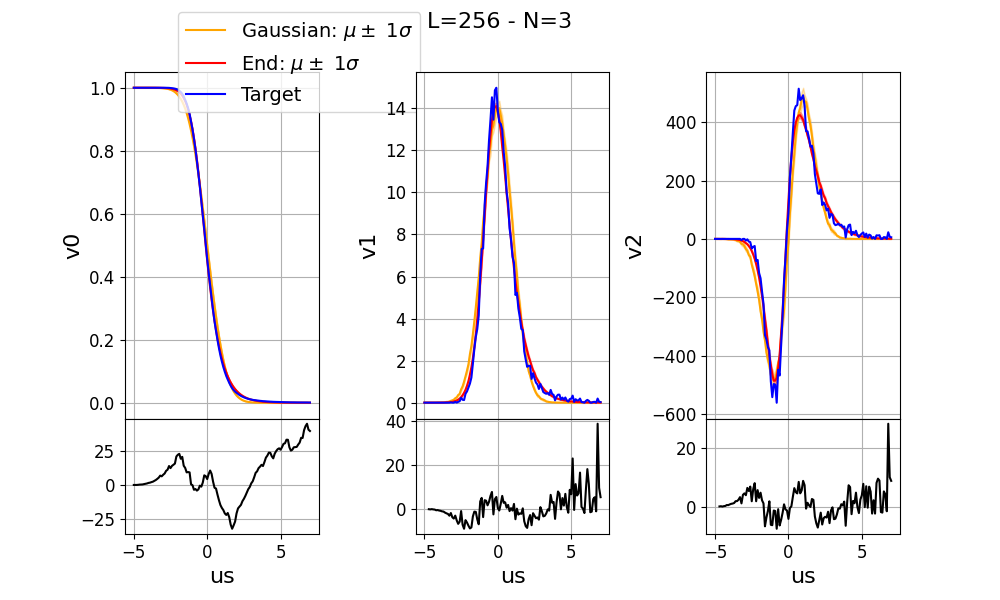

In [234]:
fig, axs = plt.subplots(2, 3, sharex='col', figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
axs = axs.ravel()
(ax0, ax1, ax2, ax3, ax4, ax5) = axs
fig.subplots_adjust(hspace=0, wspace=0.5)

fig.suptitle(f'{L=} - {N=}')
ns = 1
#ax0.plot(us, mean_v0_start, color='g', label='Start')
#ax0.fill_between(us, mean_v0_start - std_v0_start, mean_v0_start + std_v0_start, color='g', alpha=0.3)
ax0.plot(us, mean_v0_gauss, color='orange', label=fr'Gaussian: $\mu \pm$ {ns}$\sigma$')
ax0.fill_between(us, mean_v0_gauss - std_v0_gauss, mean_v0_gauss + std_v0_gauss, color='orange', alpha=0.3)
ax0.plot(us, mean_v0_end, color='r', label=fr'End: $\mu \pm$ {ns}$\sigma$')
ax0.fill_between(us, mean_v0_end - ns*std_v0_end, mean_v0_end + ns*std_v0_end, color='r', alpha=0.3)
ax0.plot(us, v0_target, color='b', label='Target')
ax0.set_ylabel('v0')
ax0.grid()
ax0.legend(loc='upper center', bbox_to_anchor=(0.9, 1.2), ncol=1, fontsize=14)

#ax1.plot(us, mean_v1_start, color='g', label='Start')
#ax1.fill_between(us, mean_v1_start - std_v1_start, mean_v1_start + std_v1_start, color='g', alpha=0.3)
ax1.plot(us, mean_v1_gauss, color='orange', label='Gaussian')
ax1.fill_between(us, mean_v1_gauss - std_v1_gauss, mean_v1_gauss + std_v1_gauss, color='orange', alpha=0.3)
ax1.plot(us, mean_v1_end, color='r', label='End')
ax1.fill_between(us, mean_v1_end - ns*std_v1_end, mean_v1_end + ns*std_v1_end, color='r', alpha=0.3)
ax1.plot(us, v1_target, color='b', label='Target')
ax1.set_ylabel('v1')
ax1.grid()

#ax2.plot(us, mean_v2_start, color='g', label='Start')
#ax2.fill_between(us, mean_v2_start - ns*std_v2_start, mean_v2_start + ns*std_v2_start, color='g', alpha=0.3)
ax2.plot(us, mean_v2_gauss, color='orange', label='Gaussian')
ax2.fill_between(us, mean_v2_gauss - ns*std_v2_gauss, mean_v2_gauss + ns*std_v2_gauss, color='orange', alpha=0.3)
ax2.plot(us, mean_v2_end, color='r', label='End')
ax2.fill_between(us, mean_v2_end - ns*std_v2_end, mean_v2_end + ns*std_v2_end, color='r', alpha=0.3)
ax2.plot(us, v2_target, color='b', label='Target')
ax2.set_ylabel('v2')
ax2.grid()
#ax2.legend()

ax3.plot(us, (v0_target - mean_v0_end)/std_v0_end, color='k')
ax3.set_xlabel('us')
ax3.grid()

ax4.plot(us, (v1_target - mean_v1_end)/std_v1_end, color='k')
ax4.set_xlabel('us')
ax4.grid()

ax5.plot(us, (v2_target - mean_v2_end)/std_v2_end, color='k')
ax5.set_xlabel('us')
ax5.grid()

#fig.tight_layout()